## Plots delays, throughputs, packet loss and path for a selected link

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
indices = "network_weather-2017.5.*"

my_query = {}

from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

import time
from sklearn.model_selection import train_test_split

import random

from pandas.tseries.offsets import *

#from graphviz import Source

##  Select your link

In [2]:
# sS='UC'
# srcSiteOWDServer = "192.170.227.160"
# srcSiteThroughputServer = "192.170.227.162"

sS= 'pic'
srcSiteOWDServer = "193.109.172.188"
#srcSiteThroughputServer = "128.142.223.246"

# dS='IU'
# destSiteOWDServer = "149.165.225.223"
# destSiteThroughputServer = "149.165.225.224"

# dS='UIUC'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.96.9"

# dS='ICCN'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.126.132"

dS= 'CERN-PROD'
destSiteOWDServer = "128.142.223.247"
#destSiteThroughputServer = "193.109.172.187"

# dS = 'RO-16-UAIC'
# destSiteOWDServer = "85.122.31.74"

# dS = 'praguelcg2'
# destSiteOWDServer = "147.231.25.192"

# dS = 'MWT2'
# destSiteOWDServer = "149.165.225.223"

# dS = 'UFlorida-HPC'
# destSiteOWDServer = "128.227.221.44"

## Get the data from Elasticsearch, and store the record based on its type

In [3]:
my_query = {
    'query': { 
       'bool':{
            'must':[
                    {'range': {'timestamp': {'gte': '20170510T000000Z', 'lt': '20170530T000000Z'}}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteOWDServer}},
                                #{'term': {'src': srcSiteThroughputServer}},
                                #{'term': {'src': destSiteOWDServer}},
                                #{'term': {'src': destSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteOWDServer}},
                                #{'term': {'dest': destSiteThroughputServer}},
                                #{'term': {'dest': srcSiteOWDServer}},
                                #{'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'_type': 'packet_loss_rate'}},
                            #{'term': {'_type': 'latency'}},
                            #{'term': {'_type': ''}},
                            #{'term': {'_type': ''}}
                            ]}
                        }
                    ]
                }
        
        }
    }


scroll = list(scan(client=es, index=indices, query=my_query))

In [4]:
site = {srcSiteOWDServer: sS, destSiteOWDServer:dS}
data = {sS:pd.DataFrame(),dS:pd.DataFrame()}
epoch = datetime.utcfromtimestamp(0)
count = 0
print(epoch)

for res in scroll:
    if count<10: print(res)
    count += 1
#     dt=datetime.strptime(res['_source']['timestamp'], '%Y-%m-%dT%H:%M:%S') # for data before Oct. 15 2016
    dt=datetime.utcfromtimestamp(res['_source']['timestamp']/1000.0)
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    data[s].set_value(ts, 'timestamp', dt)
    column_type = res['_type']
    if column_type == 'packet_loss_rate':
        data[s].set_value( ts, 'packet_loss', res['_source']['packet_loss'])
    #if count<2: print(dt)

1970-01-01 00:00:00
{'sort': [1926], '_source': {'srcProduction': True, 'srcSite': 'pic', 'timestamp': 1495154636000, 'MA': '193.109.172.188', 'src': '193.109.172.188', 'destProduction': True, 'destSite': 'CERN-PROD', 'srcVO': 'ATLAS', 'destVO': 'ATLAS', 'packet_loss': 0.0, 'dest': '128.142.223.247'}, '_id': 'AVweN7TEKw5l0ihiPr30', '_score': None, '_index': 'network_weather-2017.5.19', '_type': 'packet_loss_rate'}
{'sort': [1927], '_source': {'srcProduction': True, 'srcSite': 'pic', 'timestamp': 1495154094000, 'MA': '193.109.172.188', 'src': '193.109.172.188', 'destProduction': True, 'destSite': 'CERN-PROD', 'srcVO': 'ATLAS', 'destVO': 'ATLAS', 'packet_loss': 0.0, 'dest': '128.142.223.247'}, '_id': 'AVweN7TEKw5l0ihiPr31', '_score': None, '_index': 'network_weather-2017.5.19', '_type': 'packet_loss_rate'}
{'sort': [1928], '_source': {'srcProduction': True, 'srcSite': 'pic', 'timestamp': 1495154095000, 'MA': '193.109.172.188', 'src': '193.109.172.188', 'destProduction': True, 'destSite':

In [5]:
data[sS].sort_index(inplace=True) 
data[sS].describe()

print(data[sS])

                       timestamp  packet_loss
1.494374e+12 2017-05-10 00:00:42          0.0
1.494374e+12 2017-05-10 00:00:46          0.0
1.494375e+12 2017-05-10 00:01:42          0.0
1.494375e+12 2017-05-10 00:01:46          0.0
1.494375e+12 2017-05-10 00:02:42          0.0
1.494375e+12 2017-05-10 00:02:46          0.0
1.494375e+12 2017-05-10 00:03:42          0.0
1.494375e+12 2017-05-10 00:03:46          0.0
1.494375e+12 2017-05-10 00:04:42          0.0
1.494375e+12 2017-05-10 00:04:46          0.0
1.494375e+12 2017-05-10 00:05:42          0.0
1.494375e+12 2017-05-10 00:05:51          0.0
1.494375e+12 2017-05-10 00:06:42          0.0
1.494375e+12 2017-05-10 00:06:51          0.0
1.494375e+12 2017-05-10 00:07:43          0.0
1.494375e+12 2017-05-10 00:07:56          0.0
1.494375e+12 2017-05-10 00:08:43          0.0
1.494375e+12 2017-05-10 00:09:01          0.0
1.494375e+12 2017-05-10 00:09:43          0.0
1.494375e+12 2017-05-10 00:10:01          0.0
1.494375e+12 2017-05-10 00:10:43  

### Extract values

In [6]:
F = data[sS]
Fpl = F[F.packet_loss.notnull()]

#print(Fpl)
print(Fpl)

                       timestamp  packet_loss
1.494374e+12 2017-05-10 00:00:42          0.0
1.494374e+12 2017-05-10 00:00:46          0.0
1.494375e+12 2017-05-10 00:01:42          0.0
1.494375e+12 2017-05-10 00:01:46          0.0
1.494375e+12 2017-05-10 00:02:42          0.0
1.494375e+12 2017-05-10 00:02:46          0.0
1.494375e+12 2017-05-10 00:03:42          0.0
1.494375e+12 2017-05-10 00:03:46          0.0
1.494375e+12 2017-05-10 00:04:42          0.0
1.494375e+12 2017-05-10 00:04:46          0.0
1.494375e+12 2017-05-10 00:05:42          0.0
1.494375e+12 2017-05-10 00:05:51          0.0
1.494375e+12 2017-05-10 00:06:42          0.0
1.494375e+12 2017-05-10 00:06:51          0.0
1.494375e+12 2017-05-10 00:07:43          0.0
1.494375e+12 2017-05-10 00:07:56          0.0
1.494375e+12 2017-05-10 00:08:43          0.0
1.494375e+12 2017-05-10 00:09:01          0.0
1.494375e+12 2017-05-10 00:09:43          0.0
1.494375e+12 2017-05-10 00:10:01          0.0
1.494375e+12 2017-05-10 00:10:43  

In [7]:
#print(Fpl['timestamp'])

#### interpolate all the values and leave only onese where all 4 measurements are there

In [8]:
NF=F.interpolate(method='index',limit=1,limit_direction='both')
NFall = NF[NF.packet_loss.notnull()]

print(NFall.shape)

(51330, 2)


In [9]:
print(NF.shape)

(51330, 2)


In [10]:
print( 'packet loss forward: ', Fpl.shape[0])

packet loss forward:  51330


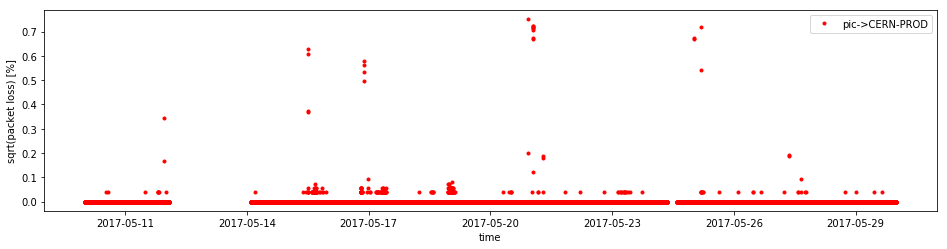

In [11]:
plt.figure(figsize=[16, 17])
gs = gridspec.GridSpec(4, 1)

ax2 = plt.subplot(gs[1])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()

plt.show()

### Boosted Decision Trees

In [12]:
start_time = time.clock()

# predicted_flag_array = np.zeros((24*3600), dtype=np.int)
# auc_score_array = np.zeros((24*3600), dtype=np.float)
# score_holder_array = np.zeros(3600, dtype=np.float)
# anomaly_array = np.ones(3600, dtype=np.int)
# not_anomaly_array = np.zeros(3600, dtype=np.int)

In [13]:
n_series = 1
start_date = '2017-08-14 00:00:00'
end_date = '2017-08-21 23:59:59'

window = 24

In [14]:
def check_for_anomaly(ref, sub):
    
    y_ref = pd.Series([0] * ref.shape[0])
    X_ref = ref
    del X_ref['auc_score']
    
    y_sub = pd.Series([1] * sub.shape[0])
    X_sub=sub
    del X_sub['auc_score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=50)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=50)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    clf = AdaBoostClassifier(n_estimators=50)
    
    #train an AdaBoost model to be able to tell the difference between the reference and subject data
    clf.fit(X_train, y_train) 

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    
    # scores = cross_val_score(clf, X, y)
    # print(scores)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    print ( "auc_score = ", auc_score, "\tfeature importances:", clf.feature_importances_)
    
    if auc_score > 0.55: 
        plot_roc(fpr, tpr, auc_score)
        #filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
        #tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
        #tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return auc_score

In [15]:
def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [16]:
start_date = Fpl['timestamp'].min()
print(start_date)
end_date = Fpl['timestamp'].max()
print(end_date)

#print(Fpl.index/1000 - 1502668800.0)

Fpl2 = Fpl.set_index('timestamp')
Fpl2['auc_score']=0.5
print(Fpl2)

2017-05-10 00:00:42
2017-05-29 23:59:38
                     packet_loss  auc_score
timestamp                                  
2017-05-10 00:00:42          0.0        0.5
2017-05-10 00:00:46          0.0        0.5
2017-05-10 00:01:42          0.0        0.5
2017-05-10 00:01:46          0.0        0.5
2017-05-10 00:02:42          0.0        0.5
2017-05-10 00:02:46          0.0        0.5
2017-05-10 00:03:42          0.0        0.5
2017-05-10 00:03:46          0.0        0.5
2017-05-10 00:04:42          0.0        0.5
2017-05-10 00:04:46          0.0        0.5
2017-05-10 00:05:42          0.0        0.5
2017-05-10 00:05:51          0.0        0.5
2017-05-10 00:06:42          0.0        0.5
2017-05-10 00:06:51          0.0        0.5
2017-05-10 00:07:43          0.0        0.5
2017-05-10 00:07:56          0.0        0.5
2017-05-10 00:08:43          0.0        0.5
2017-05-10 00:09:01          0.0        0.5
2017-05-10 00:09:43          0.0        0.5
2017-05-10 00:10:01          0.0    

In [17]:
print(Fpl2.index)

DatetimeIndex(['2017-05-10 00:00:42', '2017-05-10 00:00:46',
               '2017-05-10 00:01:42', '2017-05-10 00:01:46',
               '2017-05-10 00:02:42', '2017-05-10 00:02:46',
               '2017-05-10 00:03:42', '2017-05-10 00:03:46',
               '2017-05-10 00:04:42', '2017-05-10 00:04:46',
               ...
               '2017-05-29 23:55:33', '2017-05-29 23:55:35',
               '2017-05-29 23:56:33', '2017-05-29 23:56:35',
               '2017-05-29 23:57:33', '2017-05-29 23:57:35',
               '2017-05-29 23:58:35', '2017-05-29 23:58:38',
               '2017-05-29 23:59:35', '2017-05-29 23:59:38'],
              dtype='datetime64[ns]', name='timestamp', length=51330, freq=None)


timestamp =  2017-05-11 00:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-11 01:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-11 02:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-11 03:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-11 04:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-11 05:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-11 06:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-11 07:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-11 08:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-11 09:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-11 10:00:42
auc_score =  0.5 	feature importances: [ 0.]
timestamp =  2017-05-11 11:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-11 12:00:42
auc_score

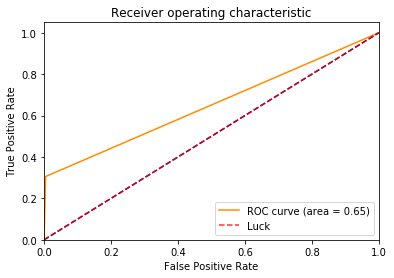

timestamp =  2017-05-16 20:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-16 21:00:42
auc_score =  0.513888888889 	feature importances: [ 0.16]
timestamp =  2017-05-16 22:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-16 23:00:42
auc_score =  0.5 	feature importances: [ 1.]
timestamp =  2017-05-17 00:00:42
auc_score =  0.5 	feature importances: [ 0.98]
timestamp =  2017-05-17 01:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-17 02:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-17 03:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-17 04:00:42
auc_score =  0.5 	feature importances: [ 0.98]
timestamp =  2017-05-17 05:00:42
auc_score =  0.5 	feature importances: [ 1.]
timestamp =  2017-05-17 06:00:42
auc_score =  0.5 	feature importances: [ 0.06]
timestamp =  2017-05-17 07:00:42
auc_score =  0.5 	feature importances: [ 0.4]
timestamp =  2017-05-17 08:00:42
a

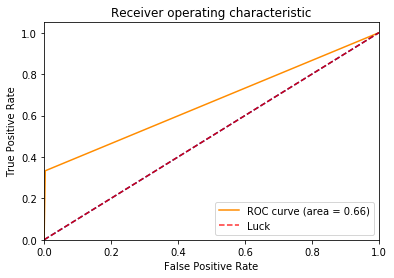

timestamp =  2017-05-19 00:00:42
auc_score =  0.5 	feature importances: [ 0.36]
timestamp =  2017-05-19 01:00:42
auc_score =  0.5 	feature importances: [ 0.66]
timestamp =  2017-05-19 02:00:42
auc_score =  0.5 	feature importances: [ 0.1]
timestamp =  2017-05-19 03:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-19 04:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-19 05:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-19 06:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-19 07:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-19 08:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-19 09:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-19 10:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-19 11:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-19 12:00:42
auc_scor

auc_score =  0.5 	feature importances: [ 0.02]
timestamp =  2017-05-23 07:00:42
auc_score =  0.5 	feature importances: [ 0.98]
timestamp =  2017-05-23 08:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-23 09:00:42
auc_score =  0.5 	feature importances: [ 0.02]
timestamp =  2017-05-23 10:00:42
auc_score =  0.5 	feature importances: [ 0.02]
timestamp =  2017-05-23 11:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-23 12:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-23 13:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-23 14:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-23 15:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-23 16:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-23 17:00:42
auc_score =  0.5 	feature importances: [ 0.02]
timestamp =  2017-05-23 18:00:42
auc_score =  0.5 	feature importances: [

auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-27 19:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-27 20:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-27 21:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-27 22:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-27 23:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-28 00:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-28 01:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-28 02:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-28 03:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-28 04:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-28 05:00:42
auc_score =  0.5 	feature importances: [ 0.04]
timestamp =  2017-05-28 06:00:42
auc_score =  0.5 	feature importances: [

In [18]:
#find min and max timestamps

start = Fpl2.index.min()
end = Fpl2.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = Fpl2[(Fpl2.index >= ref_start) & (Fpl2.index < ref_end)]
    #print('ref_df = ', ref_df)
    #print("In while loop: ref_df: ", ref_df)
    sub_df = Fpl2[(Fpl2.index >= ref_end) & (Fpl2.index < ti)]
    #print('sub_df = ', sub_df)
    #print("In while loop: sub_df: ", sub_df)
    
    ref_count = ref_df.shape[0]
    sub_count = sub_df.shape[0] 
    if ref_count < 10 or sub_count < 3:
        auc_score == 0.5
        ti = ti + sub
        count=count+1
        continue
    
    print("timestamp = ", ref_end)
    auc_score = check_for_anomaly(ref_df, sub_df)
    Fpl2.loc[(Fpl2.index>=ref_end) & (Fpl2.index<=ti),['auc_score']] = auc_score
    #print(ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tauc:', auc_score)
    ti = ti + sub
    count=count+1
    


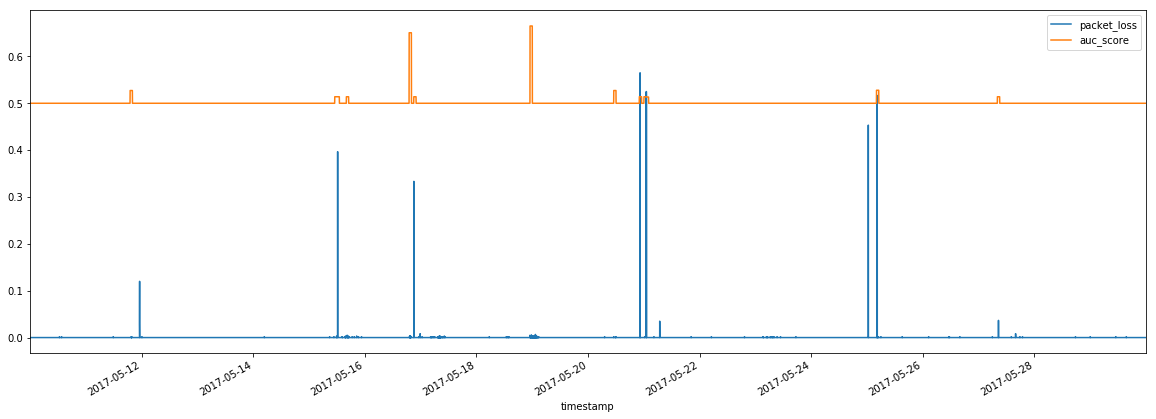

In [19]:
Fpl2.plot(figsize=(20,7))


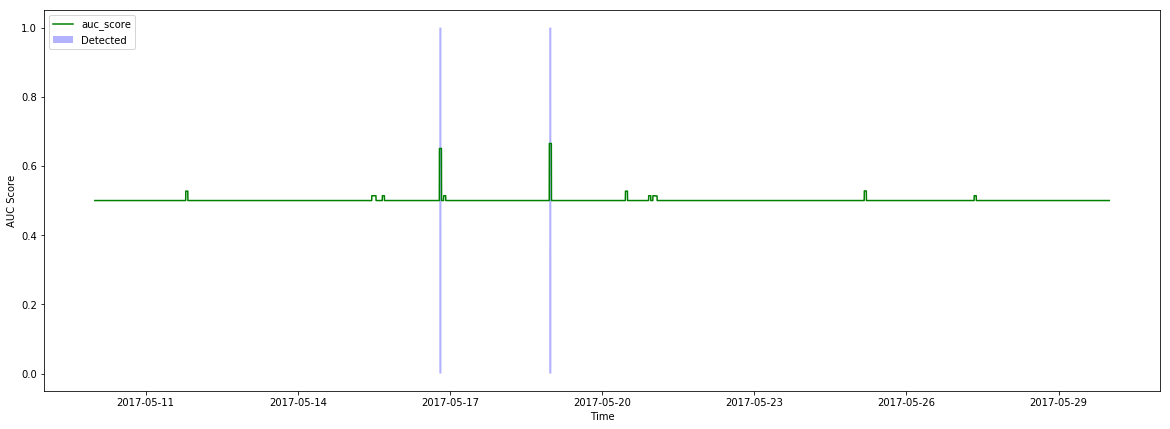

In [31]:
fig, ax = plt.subplots(figsize=(20,7))
Fpl2.loc[:,'Detected'] = 0
Fpl2.loc[Fpl2.auc_score>0.55,'Detected']=1
Fpl2.head()
#ax.plot(Fpl2.Flag, 'r')
ax.plot(Fpl2.auc_score,'g')
ax.fill( Fpl2.Detected, 'b', alpha=0.3)
ax.set_xlabel('Time')
ax.set_ylabel('AUC Score')
ax.legend(loc='upper left')

/usr/lib64/python3.4/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


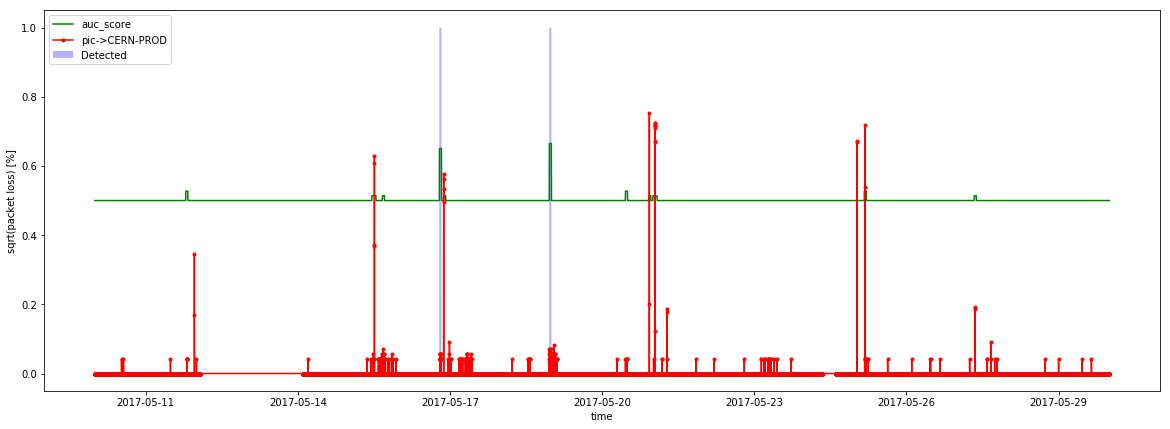

In [20]:
fig, ax = plt.subplots(figsize=(20,7))
Fpl2.loc[:,'Detected'] = 0
Fpl2.loc[Fpl2.auc_score>0.55,'Detected']=1
Fpl2.head()
#ax.plot(Fpl2.Flag, 'r')
ax.plot(Fpl2.auc_score,'g')
ax.fill( Fpl2.Detected, 'b', alpha=0.3)
ax.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', linestyle='-', marker='.', c='r', label=sS+'->'+dS)
ax.set_xlabel('time')
ax.set_ylabel('sqrt(packet loss) [%]')
ax.legend(loc='upper left')
plt.show()

In [21]:
print(Fpl2)

                     packet_loss  auc_score  Detected
timestamp                                            
2017-05-10 00:00:42          0.0        0.5         0
2017-05-10 00:00:46          0.0        0.5         0
2017-05-10 00:01:42          0.0        0.5         0
2017-05-10 00:01:46          0.0        0.5         0
2017-05-10 00:02:42          0.0        0.5         0
2017-05-10 00:02:46          0.0        0.5         0
2017-05-10 00:03:42          0.0        0.5         0
2017-05-10 00:03:46          0.0        0.5         0
2017-05-10 00:04:42          0.0        0.5         0
2017-05-10 00:04:46          0.0        0.5         0
2017-05-10 00:05:42          0.0        0.5         0
2017-05-10 00:05:51          0.0        0.5         0
2017-05-10 00:06:42          0.0        0.5         0
2017-05-10 00:06:51          0.0        0.5         0
2017-05-10 00:07:43          0.0        0.5         0
2017-05-10 00:07:56          0.0        0.5         0
2017-05-10 00:08:43         

In [22]:
#Fpl2_avg_auc_holder = Fpl2.auc_score
#Fpl2_avg_auc = Fpl2_avg_auc_holder[:'2017-08-15 00:00:00']
#Fpl2_avg_auc.mean()
#ref_start_df = pd.DataFrame(columns=['timestamp'])

#columns1 = ['timestamp', 'auc_score']
#ref_start_df = pd.DataFrame(columns=columns1) 
#ref_start_df.set_index('timestamp')

#print(ref_start_df)




In [23]:
Fpl2_avg_pkt_holder = Fpl2.packet_loss
#holds all the auc scores

timestamp_np = np.array([])
pkt_score_np = np.array([])

start = Fpl2.index.min()
end = Fpl2.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start
count=0
while ti < end + 1 * Minute():
#while start < end:
    ref_start = ti
    ref_end = ti+sub
    
    
    timestamp_np = np.append(timestamp_np, ref_start)
    #create a dataframe that stores the starting time of the each hour
    
    Fpl2_avg_pkt = math.sqrt(Fpl2_avg_pkt_holder[ref_start:ref_end].mean())
    #average packet loss score for every hour    
    
    pkt_score_np = np.append(pkt_score_np, Fpl2_avg_pkt)
    
    #start = start + sub
    
    ti = ti + sub
    #count=count+1
    #if count>2: break

timestamp1_df = pd.DataFrame(timestamp_np[:], columns=['timestamp'])
pkt_score1_df = pd.DataFrame(pkt_score_np[:], columns=['avg_packet_loss'])

pkt_avg_df1 = pd.concat([timestamp1_df, pkt_score1_df], axis=1)

pkt_avg_df2 = pkt_avg_df1.set_index('timestamp')

print(pkt_avg_df2)


                     avg_packet_loss
timestamp                           
2017-05-10 00:00:42         0.000000
2017-05-10 01:00:42         0.000000
2017-05-10 02:00:42         0.000000
2017-05-10 03:00:42         0.000000
2017-05-10 04:00:42         0.000000
2017-05-10 05:00:42         0.000000
2017-05-10 06:00:42         0.000000
2017-05-10 07:00:42         0.000000
2017-05-10 08:00:42         0.000000
2017-05-10 09:00:42         0.000000
2017-05-10 10:00:42         0.000000
2017-05-10 11:00:42         0.000000
2017-05-10 12:00:42         0.003727
2017-05-10 13:00:42         0.003727
2017-05-10 14:00:42         0.000000
2017-05-10 15:00:42         0.000000
2017-05-10 16:00:42         0.000000
2017-05-10 17:00:42         0.000000
2017-05-10 18:00:42         0.000000
2017-05-10 19:00:42         0.000000
2017-05-10 20:00:42         0.000000
2017-05-10 21:00:42         0.000000
2017-05-10 22:00:42         0.000000
2017-05-10 23:00:42         0.000000
2017-05-11 00:00:42         0.000000
2

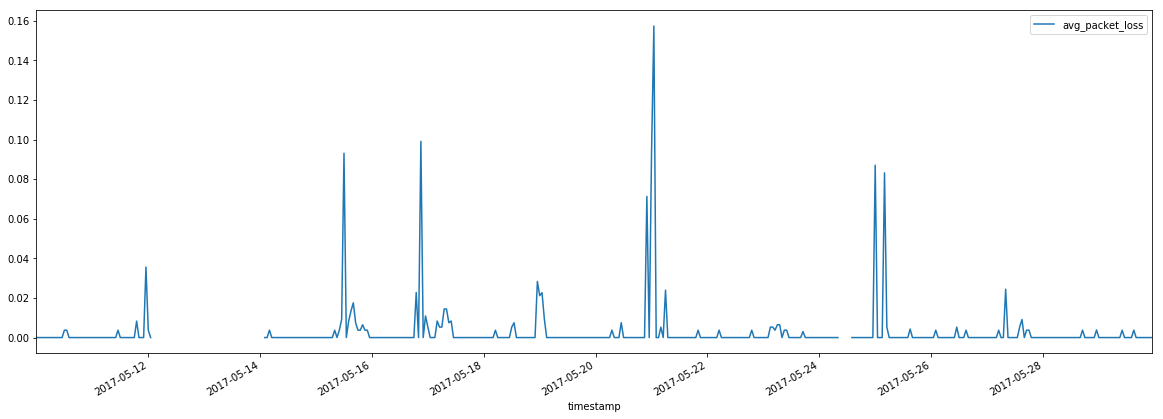

In [24]:
pkt_avg_df2.plot(figsize=(20,7))

In [25]:
# ax = pkt_avg_df2.plot()
# Fpl2.loc[:,'Detected'] = 0
# Fpl2.loc[Fpl2.auc_score>0.51,'Detected']=1
# Fpl2.plot(ax=ax, figsize=(20,7))
# ax.fill( Fpl2.Detected, 'b', alpha=0.3)

/usr/lib64/python3.4/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


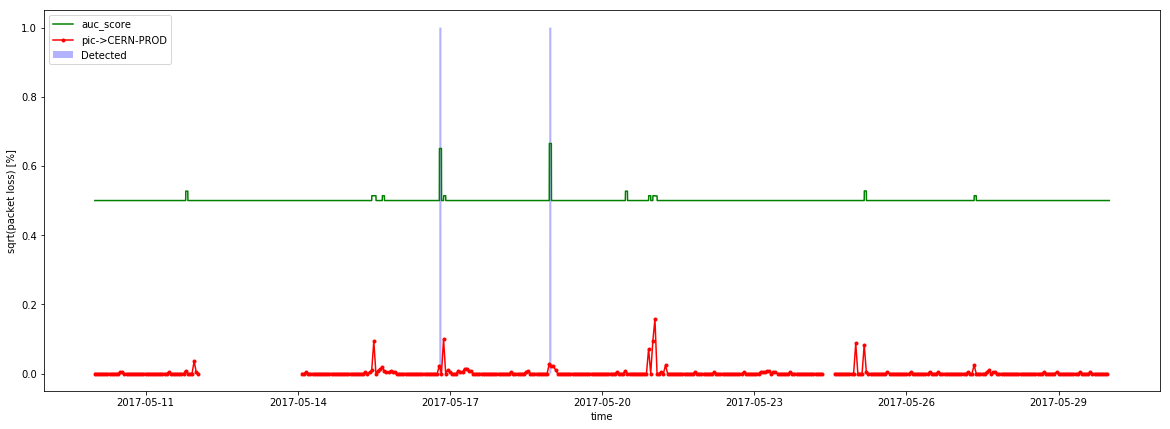

In [26]:
fig, ax = plt.subplots(figsize=(20,7))
Fpl2.loc[:,'Detected'] = 0
Fpl2.loc[Fpl2.auc_score>0.55,'Detected']=1
Fpl2.head()
#ax.plot(Fpl2.Flag, 'r')
ax.plot(Fpl2.auc_score,'g')
ax.fill( Fpl2.Detected, 'b', alpha=0.3)
ax.plot(timestamp1_df, pkt_avg_df2, ls='', linestyle='-', marker='.', c='r', label=sS+'->'+dS)
ax.set_xlabel('time')
ax.set_ylabel('sqrt(packet loss) [%]')
ax.legend(loc='upper left')
plt.show()